# Grid Square -- Lat/Lon Conversion

Based on description at https://en.wikipedia.org/wiki/Maidenhead_Locator_System

In [1]:
%pylab inline
from hamsci.gridsquare import *

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:1352: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Testing

In [2]:
# Some sample grid square - lat/lon pairs.
test_dct          = {}

tmp               = {}
test_dct['aa7bq'] = tmp
tmp['lat']        =   33.698256
tmp['lon']        = -111.891495
tmp['gs']         = 'DM43bq'

tmp               = {}
test_dct['w2naf'] = tmp
tmp['lat']        =  40.811667
tmp['lon']        = -74.210000
tmp['gs']         = 'FN20vt'

tmp               = {}
test_dct['k2mff'] = tmp
tmp['lat']        =  40.7429
tmp['lon']        = -74.1770
tmp['gs']         = 'FN20vr'

# Put everything into numpy arrays to test multiple conversions.
lats, lons, gss = [], [], []
for key,item in test_dct.iteritems():
    lats.append(item['lat'])
    lons.append(item['lon'])
    gss.append(item['gs'])

In [3]:
test_dct

{'aa7bq': {'gs': 'DM43bq', 'lat': 33.698256, 'lon': -111.891495},
 'k2mff': {'gs': 'FN20vr', 'lat': 40.7429, 'lon': -74.177},
 'w2naf': {'gs': 'FN20vt', 'lat': 40.811667, 'lon': -74.21}}

In [4]:
# Test a single location - W2NAF (40.811667, -74.210000, FN20vt)
grid_square = latlon2gridsquare(40.811667, -74.210000)
print 'Grid Square: ', grid_square

# Test multiple locations
grid_square = latlon2gridsquare(lats,lons)
print 'Grid Square: ', grid_square

Grid Square:  FN20vt
Grid Square:  ['FN20vt' 'FN20vr' 'DM43bq']


In [5]:
# Test a single location - W2NAF (40.811667, -74.210000, FN20vt)
lat,lon = gridsquare2latlon('FN20vt')
print '(lat, lon): ', lat,lon

# Test multiple locations
lat,lon = gridsquare2latlon(gss)
print '(lat, lon): ', lat,lon

(lat, lon):  40.8125 -74.2083333333
(lat, lon):  [ 40.8125      40.72916667  33.6875    ] [ -74.20833333  -74.20833333 -111.875     ]


## Map Demonstrations

In [6]:
from matplotlib import pyplot as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap

### World Map

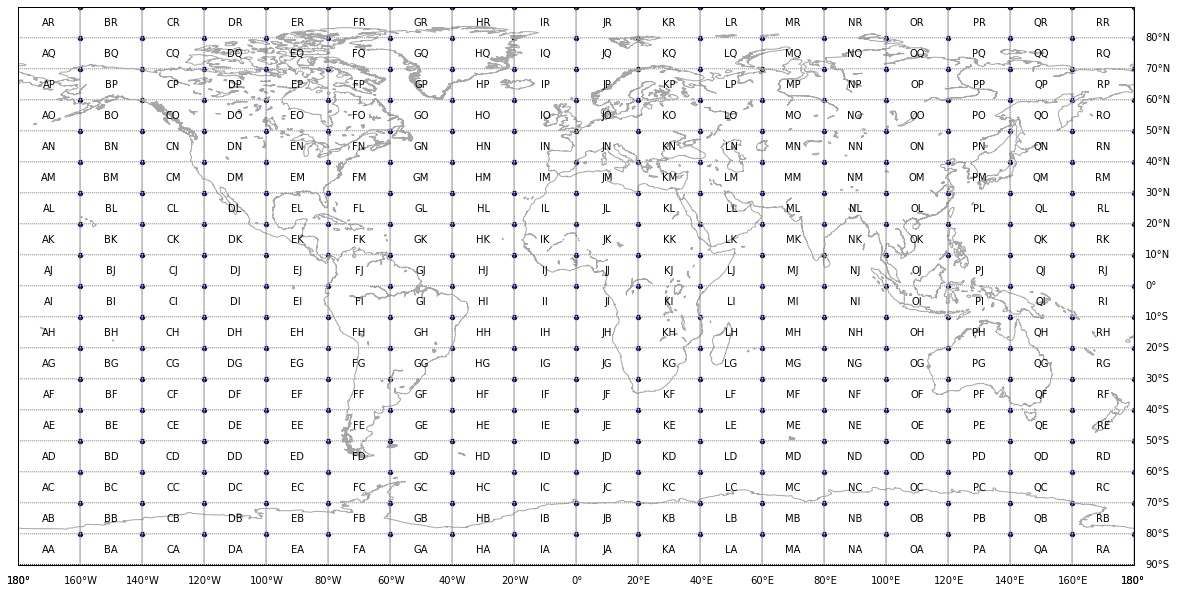

In [7]:
llcrnrlon = -180.
llcrnrlat =  -90.
urcrnrlon =  180.
urcrnrlat =   90.

fig = plt.figure(figsize=(20,15))
ax  = fig.add_subplot(111)
m   = Basemap(llcrnrlon=llcrnrlon,llcrnrlat=llcrnrlat,urcrnrlon=urcrnrlon,urcrnrlat=urcrnrlat,
            resolution='l',area_thresh=1000.,projection='cyl',ax=ax)

# Draw Grid Squares
grid_grid = gridsquare_grid(2)
lats,lons = gridsquare2latlon(grid_grid,position='lower left')

m.drawparallels(lats[0,:],color='k',labels=[False,True,True,False])
m.drawmeridians(lons[:,0],color='k',labels=[True,False,False,True])
m.drawcoastlines(color='0.65')
m.drawmapboundary(fill_color='w')

# Label Grid Squares
lats,lons = gridsquare2latlon(grid_grid)
xx,yy = m(lons,lats)
for xxx,yyy,grd in zip(xx.ravel(),yy.ravel(),grid_grid.ravel()):
    ax.text(xxx,yyy,grd,ha='center',va='center',clip_on=True)

# Test grid square location options.
lats,lons = gridsquare2latlon(grid_grid,position='upper right')
m.scatter(lons,lats)

m.drawparallels(lats[0,:],color='0.85',labels=[False,False,False,False])
m.drawmeridians(lons[:,0],color='0.85',labels=[False,False,False,False])


plt.show()

### US Map

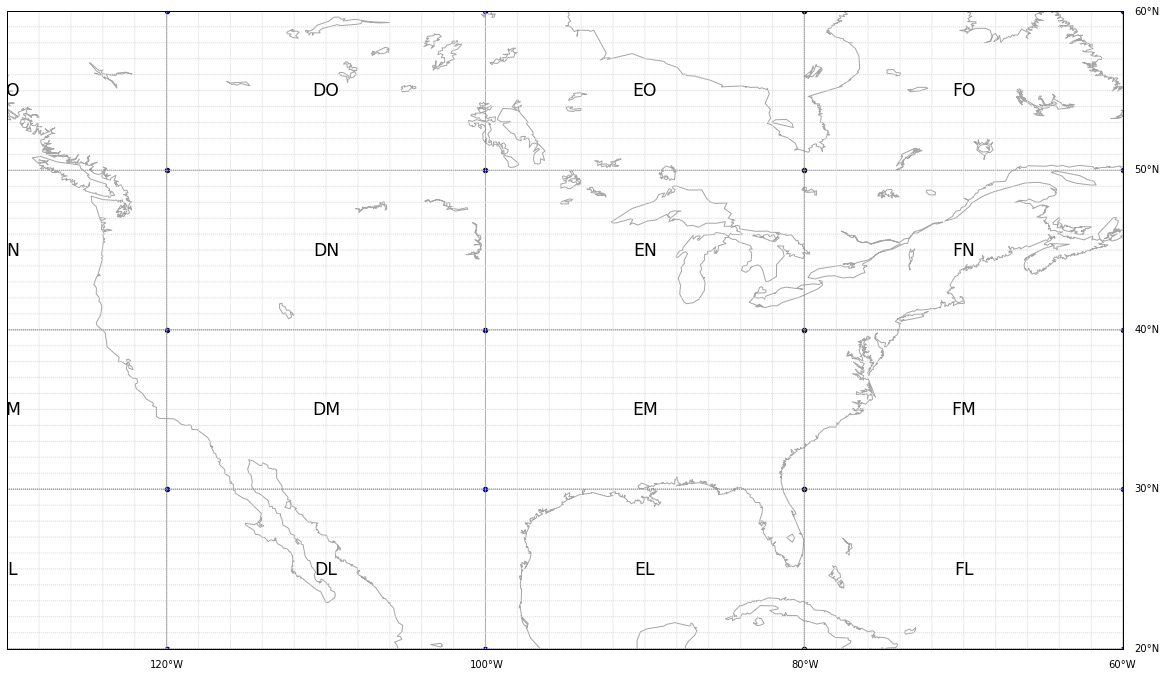

In [8]:
llcrnrlon = -130.
llcrnrlat =  20.
urcrnrlon =  -60.
urcrnrlat =   60.

fig = plt.figure(figsize=(20,15))
ax  = fig.add_subplot(111)
m   = Basemap(llcrnrlon=llcrnrlon,llcrnrlat=llcrnrlat,urcrnrlon=urcrnrlon,urcrnrlat=urcrnrlat,
            resolution='l',area_thresh=1000.,projection='cyl',ax=ax)

# Draw Grid Squares
grid_grid = gridsquare_grid(2)
lats,lons = gridsquare2latlon(grid_grid,position='lower left')

m.drawparallels(lats[0,:],color='k',labels=[False,True,True,False])
m.drawmeridians(lons[:,0],color='k',labels=[True,False,False,True])
m.drawcoastlines(color='0.65')
m.drawmapboundary(fill_color='w')

# Label Grid Squares
lats,lons = gridsquare2latlon(grid_grid)
xx,yy = m(lons,lats)
for xxx,yyy,grd in zip(xx.ravel(),yy.ravel(),grid_grid.ravel()):
    ax.text(xxx,yyy,grd,size='xx-large',
            ha='center',va='center',clip_on=True)

# Test grid square location options.
lats,lons = gridsquare2latlon(grid_grid,position='upper right')
m.scatter(lons,lats)

# Add in the precision-4 grid.
grid_grid = gridsquare_grid(4)
lats,lons = gridsquare2latlon(grid_grid,position='lower left')

m.drawparallels(lats[0,:],color='0.85',labels=[False,False,False,False])
m.drawmeridians(lons[:,0],color='0.85',labels=[False,False,False,False])


plt.show()